IMPORTATION DES LIBRAIRIES

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis, spearmanr, pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


IMPORTATION DU FICHIER EXCEL

In [3]:
file_path = "donnees_immobilieres_extended.xlsx"

#Chargement de DataFrame : nous vérifions que la base de données ait bien été importée.
try : 
    df = pd.read_excel(file_path)
    print(f"Le fichier '{file_path}' a été chargé avec succès")
except FileNotFoundError :
    print(f"Le fichier '{file_path}' est introuvable. Vérifier le dossier")
    df = pd.DataFrame()

Le fichier 'donnees_immobilieres_extended.xlsx' a été chargé avec succès


VERIFICATION DE LA COMPOSITION DES DONNEES

In [4]:
print("Shape:", df.shape)
display(df.head(5))
display(df.tail(3))
display(df.dtypes)

Shape: (150, 12)


,ID,Surface_m2,Chambres,Annee_construction,Distance_centre_km,Etage,Ascenseur,Annee_vente,Qualite_ecole,Revenu_median_quartier,Distance_universite,Prix_milliers_euros
0,1,139.87,3,1982,21.33,2,1,2023,1.1,47.5,11.9,1961.68
1,2,114.47,4,1991,2.90,5,1,2022,4.7,44.2,11.9,2303.67
2,3,145.91,2,2005,3.00,3,1,2017,3.2,53.8,10.7,2224.12
3,4,180.92,4,1995,29.61,3,1,2022,6.1,68.3,11.1,2425.63
4,5,110.63,3,2016,11.54,0,0,2021,9.0,81.9,10.8,2323.34


,ID,Surface_m2,Chambres,Annee_construction,Distance_centre_km,Etage,Ascenseur,Annee_vente,Qualite_ecole,Revenu_median_quartier,Distance_universite,Prix_milliers_euros
147,148,67.18,1,2021,7.58,4,0,2019,5.4,71.6,8.7,1902.30
148,149,140.88,3,1988,2.74,3,0,2020,5.0,54.4,9.5,2252.99
149,150,131.88,2,2006,4.30,4,0,2020,4.3,67.5,11.4,2289.51


ID                          int64
Surface_m2                float64
Chambres                    int64
Annee_construction          int64
Distance_centre_km        float64
Etage                       int64
Ascenseur                   int64
Annee_vente                 int64
Qualite_ecole             float64
Revenu_median_quartier    float64
Distance_universite       float64
Prix_milliers_euros       float64
dtype: object

ANALYSE DES DONNEES

In [5]:
#Vérifie les doublons
dup_count = df.duplicated().sum()
print("Duplicated rows:", dup_count)

#Vérifie les valeurs manquantes
na = df.isna().sum().sort_values(ascending=False)
display(na[na > 0])

#Vérifications de domaine (règles métier minimales)
checks = {}
checks["Surface_m2 <= 0"] = int((df["Surface_m2"] <= 0).sum())
checks["Chambres <= 0"] = int((df["Chambres"] <= 0).sum())
checks["Distance_centre_km < 0"] = int((df["Distance_centre_km"] < 0).sum())
checks["Distance_universite < 0"] = int((df["Distance_universite"] < 0).sum())
checks["Ascenseur not in {0,1}"] = int((~df["Ascenseur"].isin([0,1])).sum())

#Années plausibles
checks["Annee_construction < 1800"] = int((df["Annee_construction"] < 1800).sum())
checks["Annee_vente < 1990"] = int((df["Annee_vente"] < 1990).sum())
checks["Annee_construction > Annee_vente"] = int((df["Annee_construction"] > df["Annee_vente"]).sum())

display(pd.Series(checks, name="count"))

Duplicated rows: 0


Series([], dtype: int64)

Surface_m2 <= 0                     0
Chambres <= 0                       0
Distance_centre_km < 0              0
Distance_universite < 0             0
Ascenseur not in {0,1}              0
Annee_construction < 1800           0
Annee_vente < 1990                  0
Annee_construction > Annee_vente    5
Name: count, dtype: int64

DEFINITION DES VARIABLES

In [6]:
ID = "ID"
TARGET = "Prix_milliers_euros"
binary = ["Ascenseur"]
discrete = ["Chambres", "Etage", "Qualite_ecole"]  # Qualite_ecole = score (ordonné), discutable mais OK ici
continuous = ["Surface_m2", "Distance_centre_km", "Revenu_median_quartier", "Distance_universite"]
time = ["Annee_construction", "Annee_vente"]  # variables temporelles (numériques mais interprétation spécifique)
features = binary + discrete + continuous + time
assert set([ID, TARGET] + features) == set(df.columns), "Mismatch colonnes - vérifie les listes"

STATISTIQUES DESCRIPTIVES

In [7]:
#Table standard + quartiles
desc = df[features + [TARGET]].describe(percentiles=[0.25, 0.5, 0.75]).T
desc = desc.rename(columns={
    "count":"n", "mean":"mean", "50%":"median", "std":"std",
    "min":"min", "25%":"Q1", "75%":"Q3", "max":"max"
})
desc = desc[["n","mean","median","std","min","Q1","Q3","max"]]
display(desc.round(3))

,n,mean,median,std,min,Q1,Q3,max
Ascenseur,150.0,0.460,0.000,0.500,0.00,0.000,1.000,1.00
Chambres,150.0,2.887,3.000,1.078,1.00,2.000,4.000,5.00
Etage,150.0,2.580,2.500,1.762,0.00,1.000,4.000,5.00
Qualite_ecole,150.0,5.469,5.600,1.868,1.00,4.125,7.000,10.00
Surface_m2,150.0,116.707,117.845,37.694,15.21,93.240,139.638,218.53
Distance_centre_km,150.0,16.500,16.865,9.017,0.83,9.105,24.698,29.99
Revenu_median_quartier,150.0,63.668,63.450,9.295,42.90,57.500,70.475,83.90
Distance_universite,150.0,8.064,8.300,3.747,1.00,5.300,10.875,17.10
Annee_construction,150.0,2001.827,2002.500,11.705,1980.00,1991.000,2012.000,2022.00
Annee_vente,150.0,2019.840,2020.000,2.288,2015.00,2018.000,2022.000,2023.00


In [8]:
#Indicateurs “robustes” + taux d’outliers IQR
def outlier_rate_iqr(s):
    s = s.dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return float(((s < lo) | (s > hi)).mean())

def mad(s):
    s = s.dropna()
    med = np.median(s)
    return float(np.median(np.abs(s - med)))

eda = pd.DataFrame(index=features + [TARGET])
eda["skew"] = df[features + [TARGET]].apply(lambda s: skew(s.dropna()))
eda["kurtosis_excess"] = df[features + [TARGET]].apply(lambda s: kurtosis(s.dropna(), fisher=True))
eda["MAD"] = df[features + [TARGET]].apply(mad)
eda["outlier_rate_IQR"] = df[features + [TARGET]].apply(outlier_rate_iqr)

display(eda.round(3).sort_values("outlier_rate_IQR", ascending=False))


,skew,kurtosis_excess,MAD,outlier_rate_IQR
Surface_m2,0.047,-0.142,22.860,0.013
Chambres,0.097,-0.707,1.000,0.000
Ascenseur,0.161,-1.974,0.000,0.000
Etage,-0.011,-1.332,1.500,0.000
Qualite_ecole,-0.144,-0.520,1.400,0.000
Distance_centre_km,-0.141,-1.192,7.915,0.000
Revenu_median_quartier,0.051,-0.601,6.900,0.000
Distance_universite,-0.115,-0.648,2.800,0.000
Annee_construction,-0.082,-1.167,10.500,0.000
Annee_vente,-0.319,-1.012,2.000,0.000


In [9]:
#skewness & kurtosis du prix
y = df[TARGET].dropna()
print("Skewness(Prix):", skew(y))
print("Excess kurtosis(Prix):", kurtosis(y, fisher=True))


Skewness(Prix): 0.15466383953663695
Excess kurtosis(Prix): -0.4929776130918855


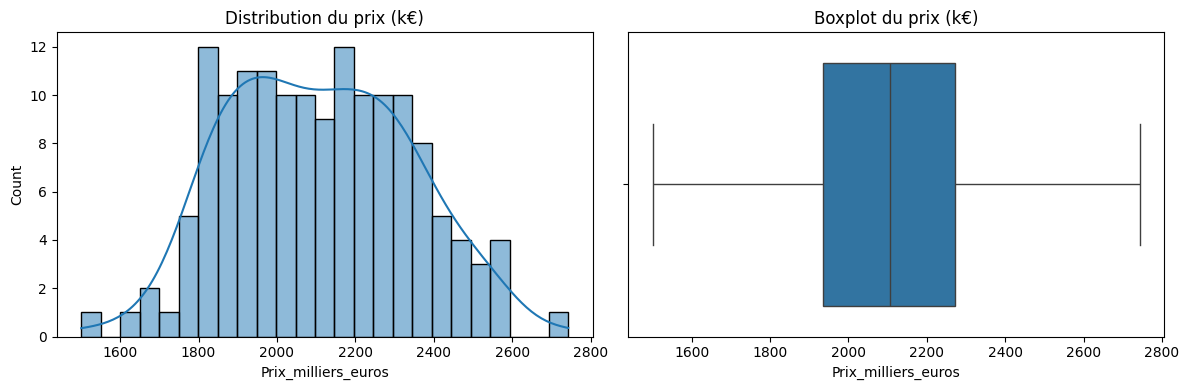

In [10]:
#Histogramme + boxplot du prix
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df[TARGET], bins=25, kde=True, ax=ax[0])
ax[0].set_title("Distribution du prix (k€)")

sns.boxplot(x=df[TARGET], ax=ax[1])
ax[1].set_title("Boxplot du prix (k€)")

plt.tight_layout()
plt.show()


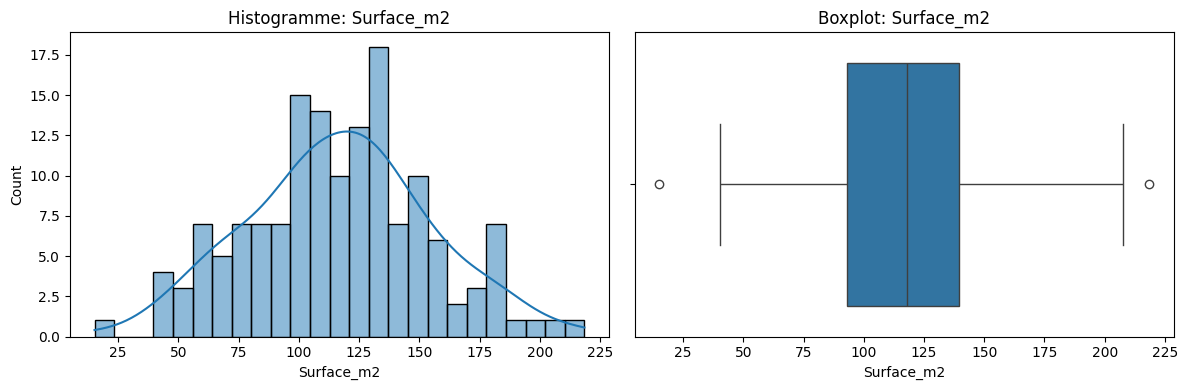

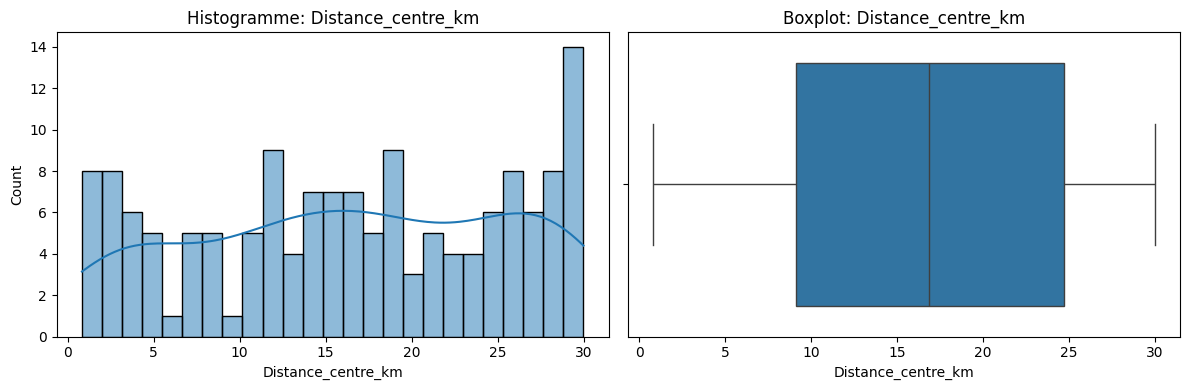

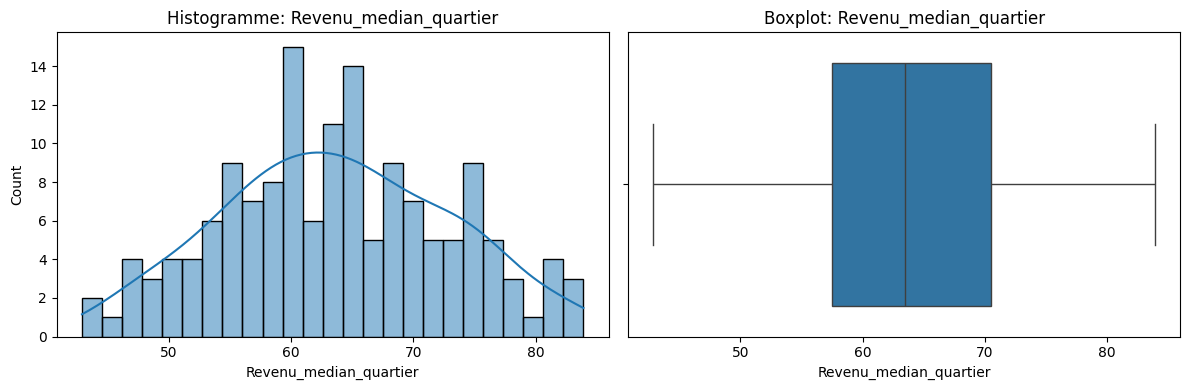

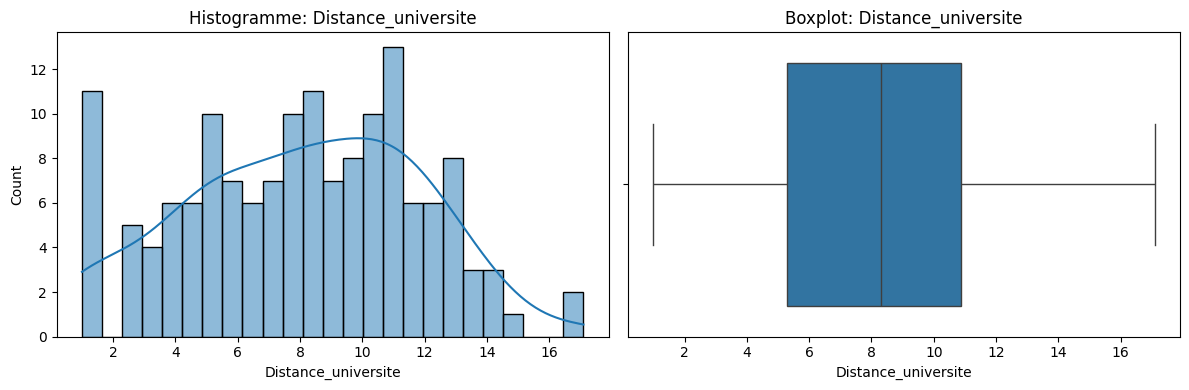

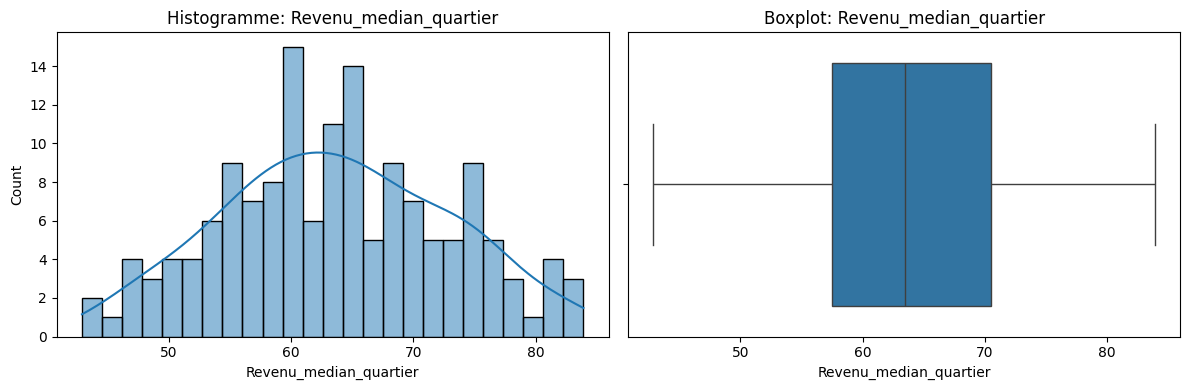

In [11]:
#Histogrammes + boxplots des variables continues
for v in continuous + ["Revenu_median_quartier"]:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[v], bins=25, kde=True, ax=ax[0])
    ax[0].set_title(f"Histogramme: {v}")
    sns.boxplot(x=df[v], ax=ax[1])
    ax[1].set_title(f"Boxplot: {v}")
    plt.tight_layout()
    plt.show()


Skew prix: 0.15466383953663695
Skew log1p(prix): -0.09429149190210759


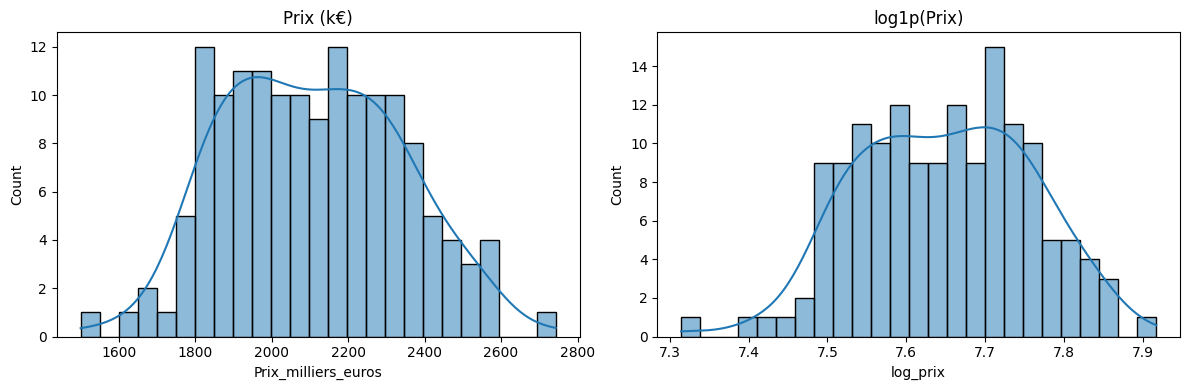

In [12]:
#Transformation log
df["log_prix"] = np.log1p(df[TARGET])

print("Skew prix:", skew(df[TARGET].dropna()))
print("Skew log1p(prix):", skew(df["log_prix"].dropna()))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df[TARGET], bins=25, kde=True, ax=ax[0]); ax[0].set_title("Prix (k€)")
sns.histplot(df["log_prix"], bins=25, kde=True, ax=ax[1]); ax[1].set_title("log1p(Prix)")
plt.tight_layout()
plt.show()


In [13]:
candidates = ["Surface_m2", "Revenu_median_quartier", "Distance_centre_km", "Distance_universite"]

for v in candidates:
    if (df[v] <= 0).any():
        continue  # log impossible si <=0
    lv = "log_" + v
    df[lv] = np.log(df[v])

    print(v, "skew:", skew(df[v].dropna()), "|", lv, "skew:", skew(df[lv].dropna()))


Surface_m2 skew: 0.047238299963779366 | log_Surface_m2 skew: -1.3907353600321453
Revenu_median_quartier skew: 0.051392557698256534 | log_Revenu_median_quartier skew: -0.2655870257464887
Distance_centre_km skew: -0.14051920604139156 | log_Distance_centre_km skew: -1.328729235221249
Distance_universite skew: -0.11525000887549569 | log_Distance_universite skew: -1.495221875907431


1.2. Corrélations

In [14]:
#Corrélation au prix
corr_pearson = df[features + [TARGET]].corr(method="pearson")[TARGET].drop(TARGET).sort_values(key=np.abs, ascending=False)
corr_spearman = df[features + [TARGET]].corr(method="spearman")[TARGET].drop(TARGET).sort_values(key=np.abs, ascending=False)

corr_compare = pd.DataFrame({"pearson": corr_pearson, "spearman": corr_spearman})
display(corr_compare)


,pearson,spearman
Annee_construction,0.068358,0.066299
Annee_vente,0.236992,0.259913
Ascenseur,0.038303,0.059775
Chambres,0.614825,0.589006
Distance_centre_km,-0.306648,-0.310988
Distance_universite,-0.124521,-0.142059
Etage,0.128403,0.120814
Qualite_ecole,0.253632,0.255205
Revenu_median_quartier,0.205779,0.198608
Surface_m2,0.826731,0.809089


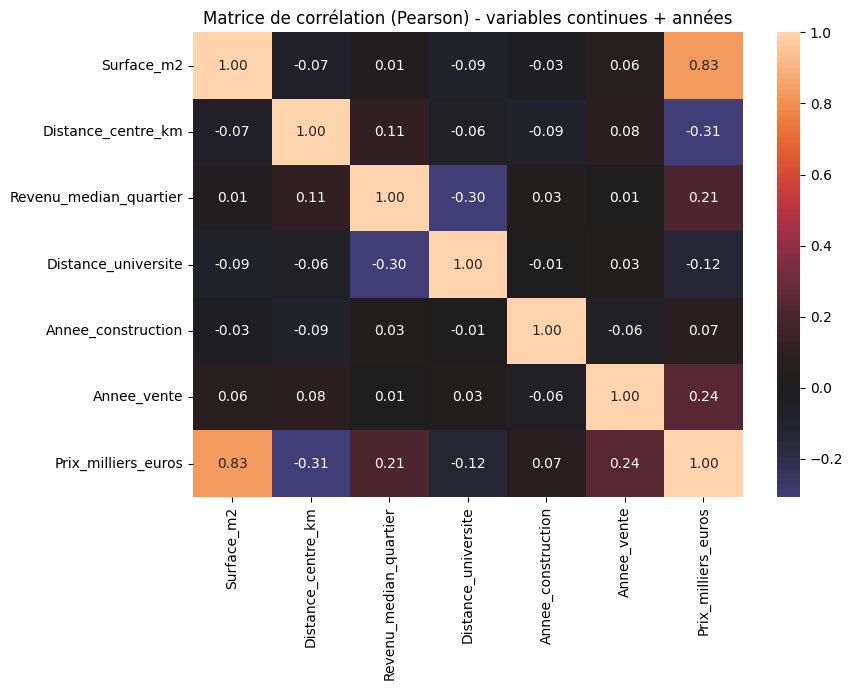

In [15]:
#Heatmap
corr_vars = continuous + time + [TARGET]
corr = df[corr_vars].corr(method="pearson")

plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt=".2f", center=0)
plt.title("Matrice de corrélation (Pearson) - variables continues + années")
plt.tight_layout()
plt.show()


In [16]:
#Paires fortement corrélées
threshold = 0.75
C = df[corr_vars].corr()

pairs = (C.where(np.triu(np.ones(C.shape), k=1).astype(bool))
           .stack()
           .reset_index())
pairs.columns = ["var1","var2","corr"]

strong_pairs = pairs.loc[pairs["corr"].abs() >= threshold].sort_values("corr", ascending=False)
display(strong_pairs)


,var1,var2,corr
5,Surface_m2,Prix_milliers_euros,0.826731


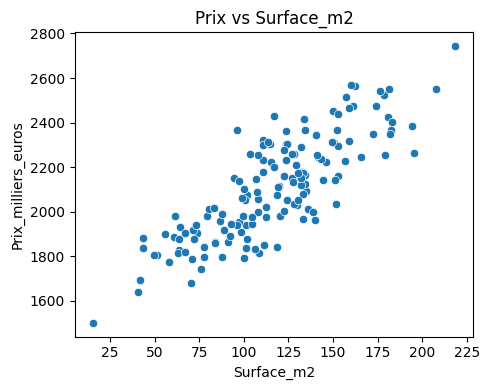

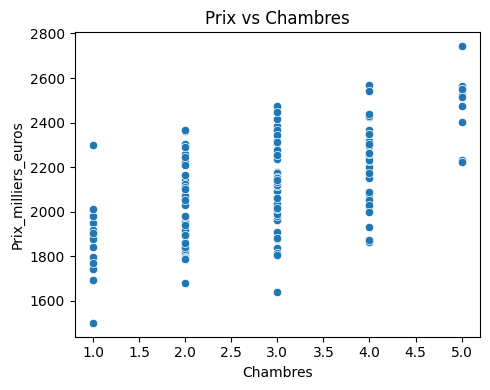

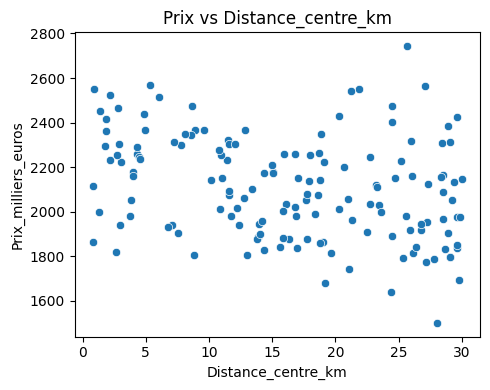

In [17]:
#Scatterplots des top relations
top3 = corr_pearson.head(3).index.tolist()
for v in top3:
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=df[v], y=df[TARGET])
    plt.title(f"Prix vs {v}")
    plt.tight_layout()
    plt.show()

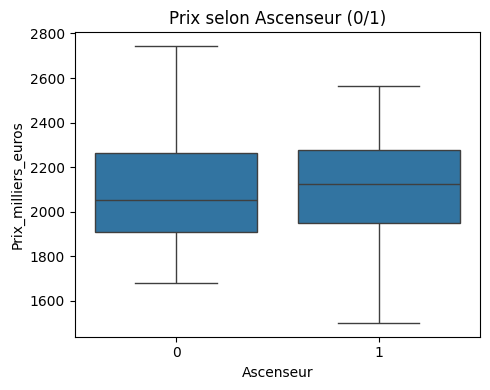

,count,mean,median,std
Ascenseur,,,,
0,81,2099.80,2050.61,232.46
1,69,2117.41,2125.50,228.23


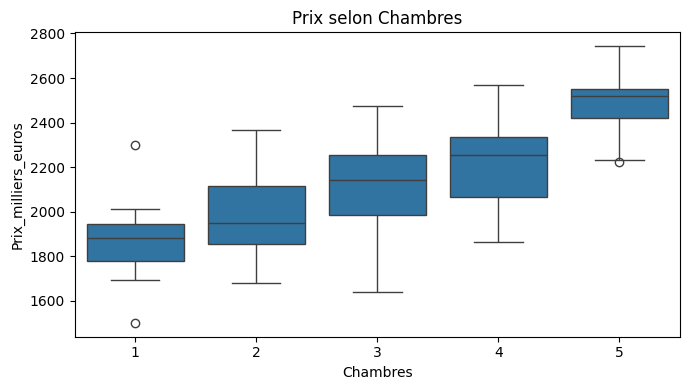

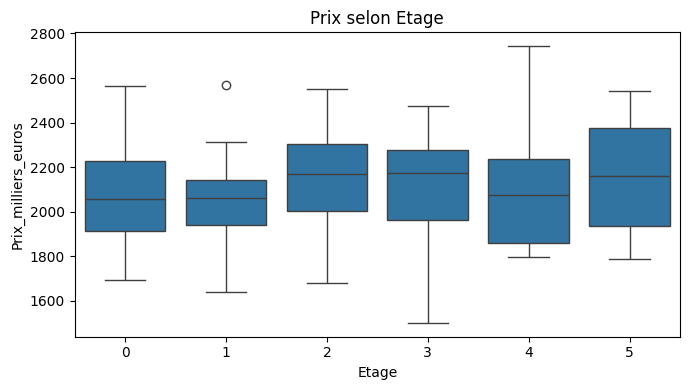

In [18]:
#Variables binaires/discrètes vs prix
#Ascenseur
plt.figure(figsize=(5,4))
sns.boxplot(x=df["Ascenseur"], y=df[TARGET])
plt.title("Prix selon Ascenseur (0/1)")
plt.tight_layout()
plt.show()

display(df.groupby("Ascenseur")[TARGET].agg(["count","mean","median","std"]).round(2))

for v in ["Chambres", "Etage"]:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=df[v], y=df[TARGET])
    plt.title(f"Prix selon {v}")
    plt.tight_layout()
    plt.show()


In [19]:
X = df[["Surface_m2"]]
y = df[TARGET]

X = sm.add_constant(X)
model_simple = sm.OLS(y, X).fit()

model_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.683
Model:                             OLS   Adj. R-squared:                  0.681
Method:                  Least Squares   F-statistic:                     319.6
Date:                 Tue, 23 Dec 2025   Prob (F-statistic):           8.45e-39
Time:                         22:09:50   Log-Likelihood:                -941.72
No. Observations:                  150   AIC:                             1887.
Df Residuals:                      148   BIC:                             1893.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1519.3743     34.584     43.932      0.000    1451.031    1587.717
Surface_m2     5.0428      0.282     17.877      0.000       4.485       5.600
==============================================================================
Omnibus:                        1.117   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.572   Jarque-Bera (JB):                1.173
Skew:                           0.131   Prob(JB):                        0.556
Kurtosis:                       2.655   Cond. No.                         400.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
table3 = pd.DataFrame({
    "coef": model_simple.params,
    "std_err": model_simple.bse,
    "t": model_simple.tvalues,
    "p_value": model_simple.pvalues
}).round(4)

table3


,coef,std_err,t,p_value
const,1519.3743,34.5845,43.9323,0.0
Surface_m2,5.0428,0.2821,17.8771,0.0


In [21]:
X_mult = df[
    ["Surface_m2", "Distance_centre_km", "Revenu_median_quartier", "Distance_universite",
     "Chambres", "Ascenseur", "Qualite_ecole", "Annee_vente", "Annee_construction"]
]
y = df[TARGET]

X_mult = sm.add_constant(X_mult)
model_mult = sm.OLS(y, X_mult).fit()

model_mult.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.891
Model:                             OLS   Adj. R-squared:                  0.884
Method:                  Least Squares   F-statistic:                     126.6
Date:                 Tue, 23 Dec 2025   Prob (F-statistic):           1.03e-62
Time:                         22:09:50   Log-Likelihood:                -862.08
No. Observations:                  150   AIC:                             1744.
Df Residuals:                      140   BIC:                             1774.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4.614e+04   5908.259     -7.809      0.000   -5.78e+04   -3.45e+04
Surface_m2                 4.2551      0.213     19.941      0.000       3.833       4.677
Distance_centre_km        -6.9778      0.730     -9.562      0.000      -8.421      -5.535
Revenu_median_quartier     2.9893      0.873      3.425      0.001       1.264       4.715
Distance_universite        3.2584      1.935      1.684      0.094      -0.568       7.085
Chambres                  36.4225      7.474      4.873      0.000      21.646      51.199
Ascenseur                 53.3182     13.096      4.071      0.000      27.427      79.209
Qualite_ecole             21.8418      4.602      4.746      0.000      12.743      30.940
Annee_vente               21.8370      2.843      7.680      0.000      16.215      27.459
Annee_construction         1.6451      0.558      2.950      0.004       0.543       2.748
==============================================================================
Omnibus:                        9.933   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               20.360
Skew:                           0.176   Prob(JB):                     3.79e-05
Kurtosis:                       4.770   Cond. No.                     2.63e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
table4 = pd.DataFrame({
    "coef": model_mult.params,
    "std_err": model_mult.bse,
    "t": model_mult.tvalues,
    "p_value": model_mult.pvalues
}).round(4)

table4

,coef,std_err,t,p_value
const,-46139.7002,5908.2589,-7.8094,0.0000
Surface_m2,4.2551,0.2134,19.9407,0.0000
Distance_centre_km,-6.9778,0.7297,-9.5621,0.0000
Revenu_median_quartier,2.9893,0.8728,3.4247,0.0008
Distance_universite,3.2584,1.9353,1.6836,0.0945
Chambres,36.4225,7.4741,4.8732,0.0000
Ascenseur,53.3182,13.0958,4.0714,0.0001
Qualite_ecole,21.8418,4.6021,4.7460,0.0000
Annee_vente,21.8370,2.8435,7.6797,0.0000
Annee_construction,1.6451,0.5577,2.9498,0.0037


In [23]:
print("R2:", round(model_mult.rsquared, 4))
print("Adj R2:", round(model_mult.rsquared_adj, 4))
print("F-stat:", round(model_mult.fvalue, 4), "| p(F):", model_mult.f_pvalue)

R2: 0.8906
Adj R2: 0.8835
F-stat: 126.5712 | p(F): 1.0262874841902611e-62


In [24]:
#pré-diagnostic multicolinéarité
X_vif = df[
    ["Surface_m2", "Distance_centre_km", "Revenu_median_quartier", "Distance_universite",
     "Chambres", "Qualite_ecole", "Annee_vente", "Annee_construction"]
].dropna()

X_vif = sm.add_constant(X_vif)

vif = pd.DataFrame({
    "variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

vif


,variable,VIF
0,const,840442.999003
6,Qualite_ecole,1.788673
3,Revenu_median_quartier,1.588558
5,Chambres,1.567681
1,Surface_m2,1.557348
4,Distance_universite,1.270722
2,Distance_centre_km,1.042918
8,Annee_construction,1.019259
7,Annee_vente,1.016188


In [25]:
desc.to_csv("Tableau2_stats_descriptives.csv")
table3.to_csv("Tableau3_modele_simple.csv")
table4.to_csv("Tableau4_modele_multiple.csv")
vif.to_csv("Diagnostic_VIF.csv", index=False)

4. Tests et inférences

In [26]:
#On reconstitue le modèle multiple sur lequelle nous allons faire des tests
vars_x = [
    "Surface_m2","Chambres","Annee_construction","Distance_centre_km",
    "Etage","Ascenseur","Annee_vente","Qualite_ecole","Revenu_median_quartier"
]

df_reg = df.dropna(subset=[TARGET] + vars_x).copy()

X = sm.add_constant(df_reg[vars_x])
y = df_reg[TARGET]

model_mult = sm.OLS(y, X).fit()
model_mult.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.893
Model:                             OLS   Adj. R-squared:                  0.886
Method:                  Least Squares   F-statistic:                     129.9
Date:                 Tue, 23 Dec 2025   Prob (F-statistic):           2.02e-63
Time:                         22:09:50   Log-Likelihood:                -860.33
No. Observations:                  150   AIC:                             1741.
Df Residuals:                      140   BIC:                             1771.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4.509e+04   5864.560     -7.689      0.000   -5.67e+04   -3.35e+04
Surface_m2                 4.2294      0.211     20.050      0.000       3.812       4.646
Chambres                  35.1511      7.367      4.771      0.000      20.585      49.717
Annee_construction         1.6996      0.552      3.080      0.002       0.609       2.791
Distance_centre_km        -7.0565      0.720     -9.796      0.000      -8.481      -5.632
Etage                      9.1322      3.666      2.491      0.014       1.884      16.380
Ascenseur                 54.9263     12.971      4.235      0.000      29.282      80.570
Annee_vente               21.2810      2.825      7.532      0.000      15.695      26.867
Qualite_ecole             19.9149      4.276      4.658      0.000      11.462      28.368
Revenu_median_quartier     2.7593      0.865      3.192      0.002       1.050       4.468
==============================================================================
Omnibus:                        8.741   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               15.517
Skew:                           0.199   Prob(JB):                     0.000427
Kurtosis:                       4.524   Cond. No.                     2.64e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.1.1 Test : la distance au centre a-t-elle un effet négatif sur le prix ?

**Étape 1 — Formulation des hypothèses**

On souhaite tester si la distance au centre-ville a un effet négatif sur le prix des logements.

Hypothèse nulle :  
H0 : β_Distance_centre_km ≥ 0  
(la distance au centre n’a pas d’effet négatif sur le prix)

Hypothèse alternative :  
H1 : β_Distance_centre_km < 0  
(la distance au centre a un effet négatif sur le prix)

Ce test est un test unilatéral à gauche.



In [27]:
t = model_mult.tvalues["Distance_centre_km"]
p_two = model_mult.pvalues["Distance_centre_km"]

# p-value unilatérale pour H1: beta < 0
p_one = p_two/2 if t < 0 else 1 - p_two/2

beta = model_mult.params["Distance_centre_km"]

print("beta_distance =", beta)
print("t-stat =", t)
print("p-value (one-sided, H1: beta < 0) =", p_one)


beta_distance = -7.056502851202567
t-stat = -9.795534946840672
p-value (one-sided, H1: beta < 0) = 7.068721187319874e-18
